In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

print('PyTorch Version : ', torch.__version__)
print('GPU : ', torch.cuda.device_count())

PyTorch Version :  2.2.1+cu121
GPU :  1


In [ ]:
GPUNUM = torch.cuda.device_count()
if GPUNUM == 0:
    torch.cuda.is_available = lambda : False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def client_update(client_model, optimizer, train_loader, epoch=5):
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            if GPUNUM == 0:
                data, target = data.cpu(), target.cpu()
            else :
                data, target = data.cuda(), target.cuda()
            # data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

def test(global_model, test_loader):
    global_model.eval()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if GPUNUM == 0:
                data, target = data.cpu(), target.cpu()
            else :
                data, target = data.cuda(), target.cuda()
            # data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [ ]:
# IID case: all the clients have images of all the classes

# Hyperparameters

num_clients = 100
num_selected = 10
num_rounds = 5
epochs = 5
batch_size = 32

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

if GPUNUM == 0:
    global_model = Net().cpu()
    client_models = [Net().cpu() for _ in range(num_selected)]
else:
    global_model = Net().cuda()
    client_models = [Net().cuda() for _ in range(num_selected)]

# global_model = Net().cuda()
# client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

# Runnining FL

for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)

    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)

    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 5094666.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 134313.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1272797.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 10192899.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

0-th round
average train loss 0.592 | test loss 0.555 | test acc: 0.835
1-th round
average train loss 0.203 | test loss 0.248 | test acc: 0.928
2-th round
average train loss 0.0465 | test loss 0.204 | test acc: 0.944
3-th round
average train loss 0.0211 | test loss 0.173 | test acc: 0.953
4-th round
average train loss 0.0159 | test loss 0.155 | test acc: 0.957


In [ ]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Hyperparameters

num_clients = 100
num_selected = 5
num_rounds = 50
epochs = 5
batch_size = 32

# Creating decentralized datasets

traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(60000 / num_clients))
traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers
if GPUNUM == 0:
    global_model = Net().cpu()
    client_models = [Net().cpu() for _ in range(num_selected)]
else:
    global_model = Net().cuda()
    client_models = [Net().cuda() for _ in range(num_selected)]
# global_model = Net().cuda()
# client_models = [Net().cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

# Runnining FL

for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # client update
    loss = 0
    for i in range(num_selected):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)

    # serer aggregate
    server_aggregate(global_model, client_models)
    test_loss, acc = test(global_model, test_loader)

    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))

0-th round
average train loss 0.0171 | test loss 2.21 | test acc: 0.211
1-th round
average train loss 0.0155 | test loss 1.86 | test acc: 0.371
2-th round
average train loss 0.00351 | test loss 2.73 | test acc: 0.198
3-th round
average train loss 0.00478 | test loss 2.16 | test acc: 0.348
4-th round
average train loss 0.0352 | test loss 2.46 | test acc: 0.240
5-th round
average train loss 0.0262 | test loss 1.45 | test acc: 0.354
6-th round
average train loss 0.00178 | test loss 1.36 | test acc: 0.606
7-th round
average train loss 0.0073 | test loss 2.82 | test acc: 0.295
8-th round
average train loss 0.00372 | test loss 1.56 | test acc: 0.422
9-th round
average train loss 0.00212 | test loss 0.999 | test acc: 0.680
10-th round
average train loss 0.000704 | test loss 1.23 | test acc: 0.621
11-th round
average train loss 0.0031 | test loss 0.715 | test acc: 0.754
12-th round
average train loss 0.00281 | test loss 1.27 | test acc: 0.561
13-th round
average train loss 0.00119 | test loss 

Trainig complete


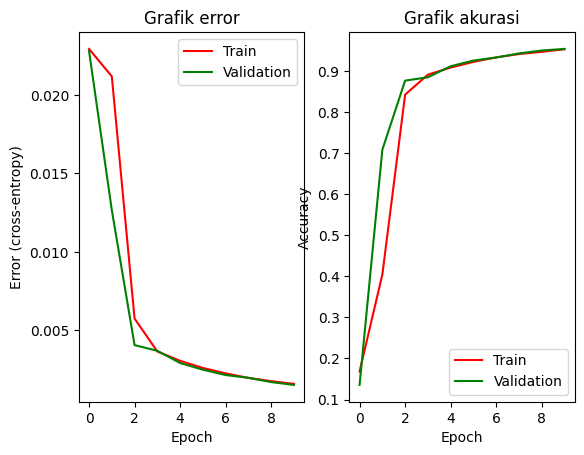

Test accuracy : 0.9587


In [ ]:
# Local, Centralization Case : Classic deep learning training method.

# Hyperparameters

"""CNN MNIST.ipynb

Automatically generated by Colaboratory. Original file is located at

https://colab.research.google.com/drive/14YB2h3vxvxOanJc1yDDEqw0O4atiz7Rm

https://github.com/dandiws/CNN-MNIST-pytorch/blob/master/cnn_mnist.py

"""

batch_size = 100
validation_split = .1
shuffle_dataset = True
random_seed= 2


train_ds = datasets.MNIST('./data',train=True,download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Creating data indices for training and validation splits:
dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader( datasets.MNIST('./data',train=False,download=True,
    transform=transforms.Compose([transforms.ToTensor()])),batch_size=batch_size,shuffle=True)

if GPUNUM == 0:
    model = Net().cpu()
else:
    model = Net().cuda()
# model = Net().cuda()
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(validation_loader)*batch_size

for i in range(10):
  total_loss = 0
  total_acc = 0
  c = 0
  for images,labels in train_loader:
    if GPUNUM == 0:
      images = images.cpu()
      labels = labels.cpu()
    else:
      images = images.cuda()
      labels = labels.cuda()
    # images = images.cuda()
    # labels = labels.cuda()

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1

  # Validation
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in validation_loader:
    if GPUNUM == 0:
      images = images.cpu()
      labels = labels.cpu()
    else:
      images = images.cuda()
      labels = labels.cuda()
    output = model(images)
    loss = criterion(output,labels)

    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1

  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)

print("Trainig complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Grafik error")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Grafik akurasi")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0

print("Test accuracy :",total_acc/len(test_loader.dataset))